<a href="https://colab.research.google.com/github/nitrogenlab/GP15_watermassanalysis/blob/main/ThermoclineSplittingDev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y pyompa
%cd /content/
!rm -rf pyompa
!git clone https://github.com/nitrogenlab/pyompa
%cd /content/pyompa
!git checkout dev
!git log -1
!pip install .
%cd /content/

%reload_ext autoreload
%autoreload 2
from importlib import reload
import pyompa
reload(pyompa)

/content
Cloning into 'pyompa'...
remote: Enumerating objects: 275, done.
remote: Counting objects: 100% (275/275), done.
remote: Compressing objects: 100% (178/178), done.
remote: Total 595 (delta 181), reused 171 (delta 90), pack-reused 320
Receiving objects: 100% (595/595), 102.32 KiB | 667.00 KiB/s, done.
Resolving deltas: 100% (405/405), done.
/content/pyompa
Branch 'dev' set up to track remote branch 'dev' from 'origin'.
Switched to a new branch 'dev'
commit bc577e3193bab6e5e8ff6a297056a916cb1677ec (HEAD -> dev, origin/dev)
Author: Avanti Shrikumar <avanti.shrikumar@gmail.com>
Date:   Tue Jan 19 19:03:38 2021 -0800

    bugfix
Processing /content/pyompa
  Created wheel for pyompa: filename=pyompa-0.3.0.3-cp36-none-any.whl size=18177 sha256=2b6da717965a500743a0b6c24a48d67d022623c456fb8bbd89e28242460abe61
  Stored in directory: /tmp/pip-ephem-wheel-cache-7vhqdfaq/wheels/c8/e7/18/86bb9113ba57075c1244f892ac172edfebb6b9de263279873f
Successfully built pyompa
/content


<module 'pyompa' from '/usr/local/lib/python3.6/dist-packages/pyompa/__init__.py'>

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ' -O names_added_GP15OMPA_33RR20180918_only_gs_rosette_clean1_hy1.csv

--2021-01-24 04:22:24--  https://docs.google.com/uc?export=download&id=1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ
Resolving docs.google.com (docs.google.com)... 173.194.69.101, 173.194.69.139, 173.194.69.100, ...
Connecting to docs.google.com (docs.google.com)|173.194.69.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7b1k749hu0oejv0or9kg3kig3hmh34hg/1611462075000/06203730782251856755/*/1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ?e=download [following]
--2021-01-24 04:22:24--  https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7b1k749hu0oejv0or9kg3kig3hmh34hg/1611462075000/06203730782251856755/*/1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ?e=download
Resolving doc-0s-a4-docs.googleusercontent.com (doc-0s-a4-docs.googleusercontent.com)... 108.177.119.132, 2a00:1450:4013:c00::84
Connecting to doc-0s-a4-docs.googleusercontent.com (doc-0s-a4-

In [ ]:
!pip install gsw

     |████████████████████████████████| 2.4MB 12.3MB/s 


In [ ]:
import pandas as pd
import numpy as np
import gsw

def augment_df_with_PO_NO_SiO(df):  
  #remineralization ratios
  r_PO = 155;
  r_SiO = 15
  r_NO = 9.68
  df["PO"] = df["oxygen"] + df["phosphate"]*r_PO
  df["NO"] = df["oxygen"] + df["nitrate"]*r_NO
  df["SiO"] = df["oxygen"] + df["silicate"]*r_SiO

header = ["c"+str(i) for i in range(1,30)]
header[4] = "bottle flag"
header[16] = "bottle salinity flag"
header[20] = "bottle oxygen flag"
header[22] = "silicate flag"
header[24] = "nitrate flag"
header[28] = "phosphate flag"

header[11] = "CTD pressure"
header[12] = "CTD temperature"
header[15] = "practical_salinity" #practical salinity
header[8] = "lat"
header[9] = "lon"

header[0] = "stnnbr"
header[5] = "geotrc_ID"
header[10] = "bottom depth"
header[19] = "oxygen"
header[21] = "silicate"
header[23] = "nitrate"
header[27] = "phosphate"

gp15_df = pd.read_csv("names_added_GP15OMPA_33RR20180918_only_gs_rosette_clean1_hy1.csv",
                      names=header, na_values = -999)

#remove bad data
for flag_type in ["bottle flag", "bottle salinity flag", "bottle oxygen flag",
                  "silicate flag", "nitrate flag", "phosphate flag"]:
    gp15_df = gp15_df[gp15_df[flag_type] <= 2]
gp15_df = pd.DataFrame(gp15_df)

#create PO offset
#gp15_df["phosphate"] = gp15_df["phosphate"] - 0.2

#add PO and NO to data frame
augment_df_with_PO_NO_SiO(gp15_df)

absolute_salinity = gsw.SA_from_SP(SP=gp15_df["practical_salinity"],
                                   p=gp15_df["CTD pressure"],
                                   lon=gp15_df["lon"],
                                   lat=gp15_df["lat"])
gp15_df["absolute_salinity"] = absolute_salinity

conservative_temp = gsw.CT_from_t(SA=absolute_salinity,
                                  t=gp15_df["CTD temperature"],
                                  p=gp15_df["CTD pressure"])
gp15_df["conservative_temp"] = conservative_temp

potential_temp = gsw.pt_from_CT(SA=absolute_salinity,
                                CT=conservative_temp)
gp15_df["potential_temp"] = potential_temp

sig0 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=0) - 1000
gp15_df["sigma0"] = sig0

z = gsw.z_from_p(p=gp15_df["CTD pressure"], lat=gp15_df["lat"])
depth = -z #https://github.com/TEOS-10/python-gsw/blob/7d6ebe8114c5d8b4a64268d36100a70e226afaf6/gsw/gibbs/conversions.py#L577
gp15_df["depth"] = depth

spic0 = gsw.spiciness0(SA=absolute_salinity, CT=conservative_temp)
gp15_df["spiciness"] = spic0

#calculation of planetary vorticity
rho_ref = 1000.0 #reference density
Omega = 2*np.pi/86400;
f = np.mean(2*Omega*np.sin(gp15_df["lat"]*(np.pi/180.0)))
PV = -(f/rho_ref)*(np.gradient(sig0, depth))
gp15_df["PV"] = PV #potential vorticity

print("Rows:",len(gp15_df))
gp15_df = gp15_df.dropna()
print("Rows without NA values:",len(gp15_df))

Rows: 940
Rows without NA values: 926


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1072: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1073: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1074: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1080: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


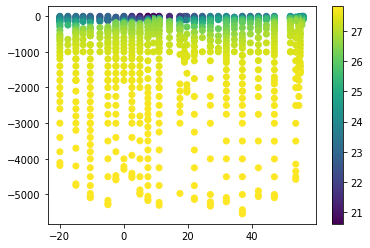

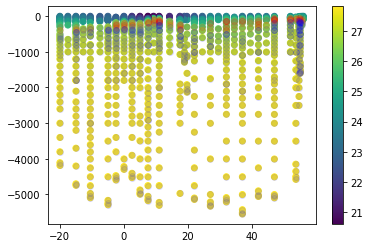

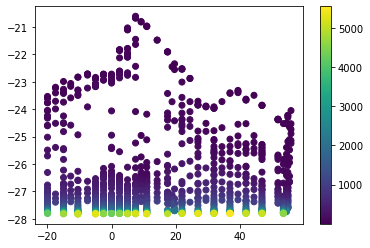

In [ ]:
gp15_df.columns

from matplotlib import pyplot as plt
plt.scatter(gp15_df["lat"], -gp15_df["depth"], c=gp15_df["sigma0"])
plt.colorbar()
plt.show()

plt.scatter(gp15_df["lat"], -gp15_df["depth"], c=gp15_df["sigma0"])
plt.colorbar()

TC_UPPER_BOUND = 26.6
TC_LOWER_BOUND = 25.5
gp15_thermocline = gp15_df[(gp15_df["sigma0"] >= TC_LOWER_BOUND)
                            & (gp15_df["sigma0"] <= TC_UPPER_BOUND)]
gp15_intermediateanddeep = pd.DataFrame(gp15_df[(gp15_df["sigma0"] >= 26.6)])

plt.scatter(gp15_thermocline["lat"], -gp15_thermocline["depth"],
            c="red", alpha=0.1)

plt.scatter(gp15_intermediateanddeep["lat"], -gp15_intermediateanddeep["depth"],
            c="blue", alpha=0.1)
plt.show()

plt.scatter(gp15_df["lat"], -gp15_df["sigma0"], c=gp15_df["depth"])
plt.colorbar()
plt.show()


In [ ]:
gp15_df

stnnbr  c2  c3  c4  ...     sigma0        depth  spiciness            PV
0        1.0   3  36  36  ...  24.052467     2.477227  -1.235624 -6.847071e-10
2        1.0   3  24  24  ...  24.533620    30.715490  -1.050415 -7.829064e-10
3        1.0   3  18  18  ...  24.737235    40.721797  -1.209639 -7.433318e-10
4        1.0   3  13  13  ...  24.894944    50.133222  -1.080744 -6.155510e-10
5        1.0   3   7   7  ...  25.144753    70.638720  -1.230846 -3.744648e-10
...      ...  ..  ..  ..  ...        ...          ...        ...           ...
1137    39.0  12  16  17  ...  27.760561  3000.792840  -0.117884 -2.062249e-12
1138    39.0  12  13  14  ...  27.779610  3401.198658  -0.122707 -1.730980e-12
1139    39.0  12  10  11  ...  27.795069  3801.952551  -0.128901 -1.164123e-12
1140    39.0  12   7   8  ...  27.801685  4107.626461  -0.130510 -6.648035e-13
1141    39.0  12   4   5  ...  27.802891  4186.879292  -0.130929 -6.116598e-13

[926 rows x 39 columns]

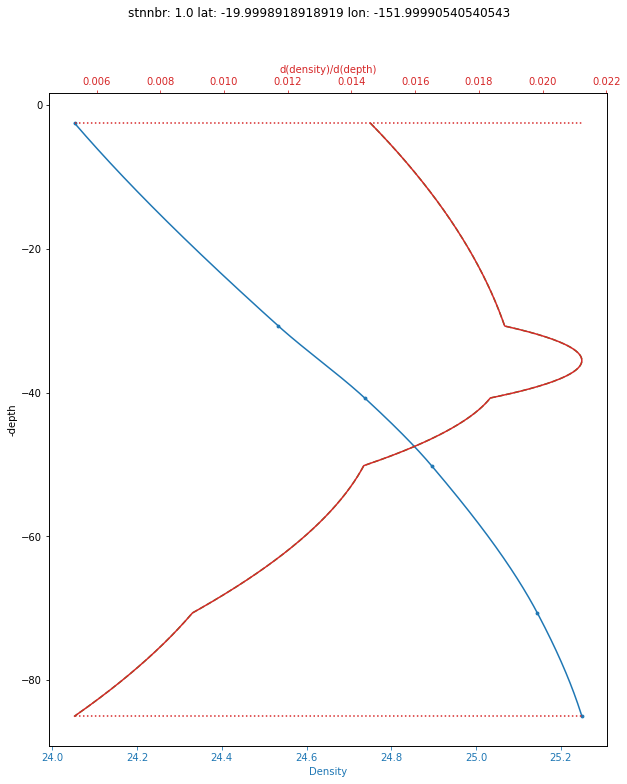

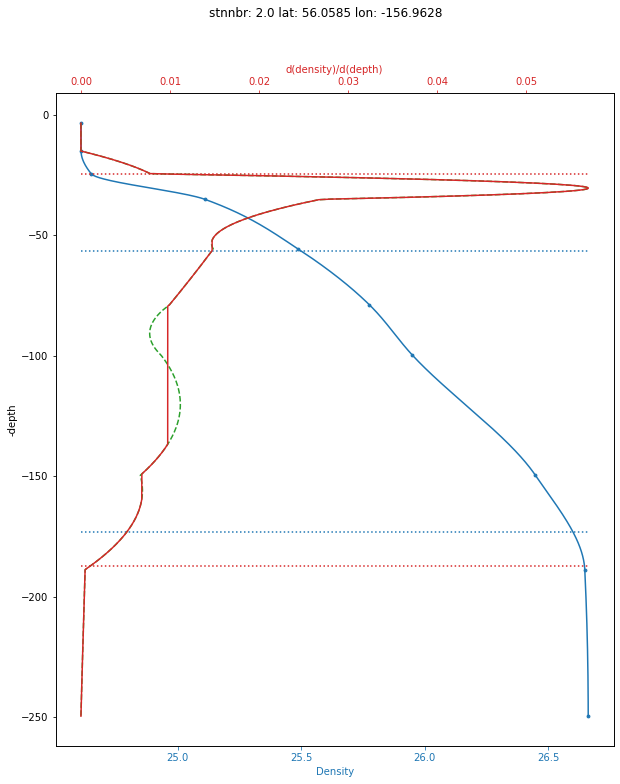

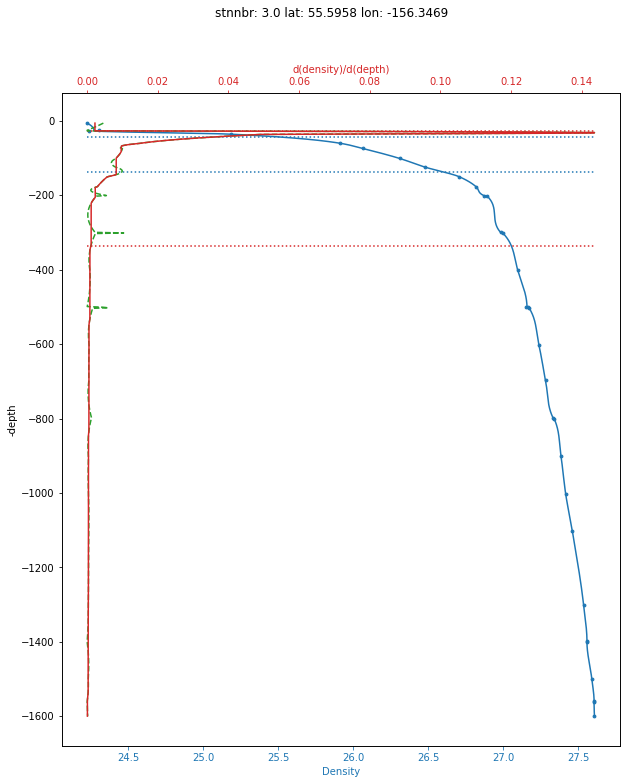

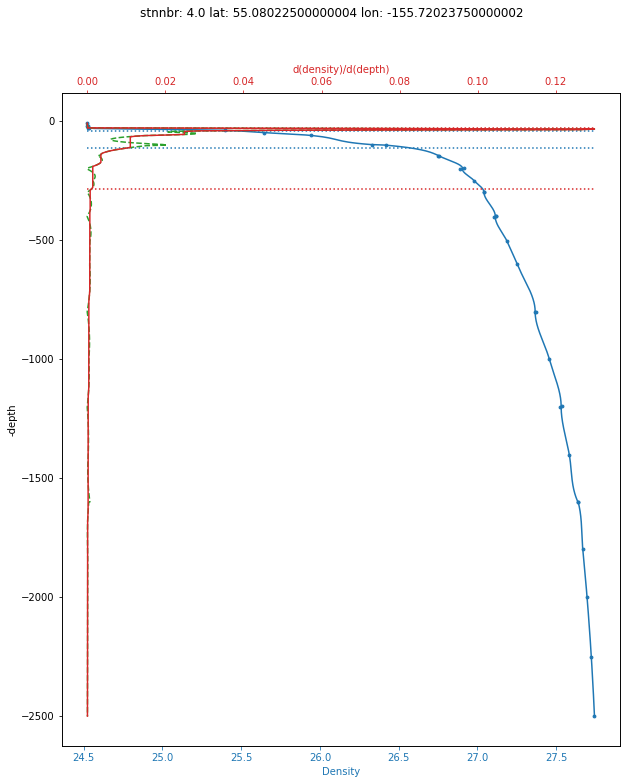

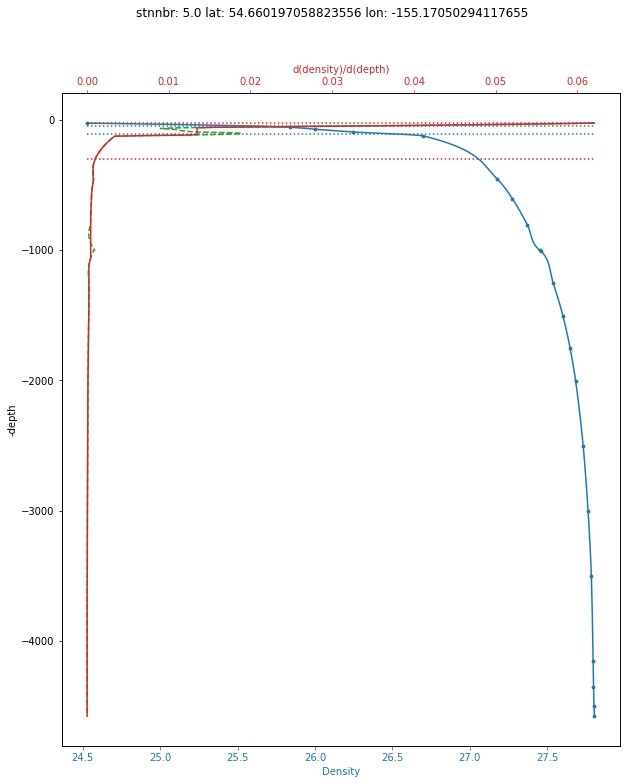

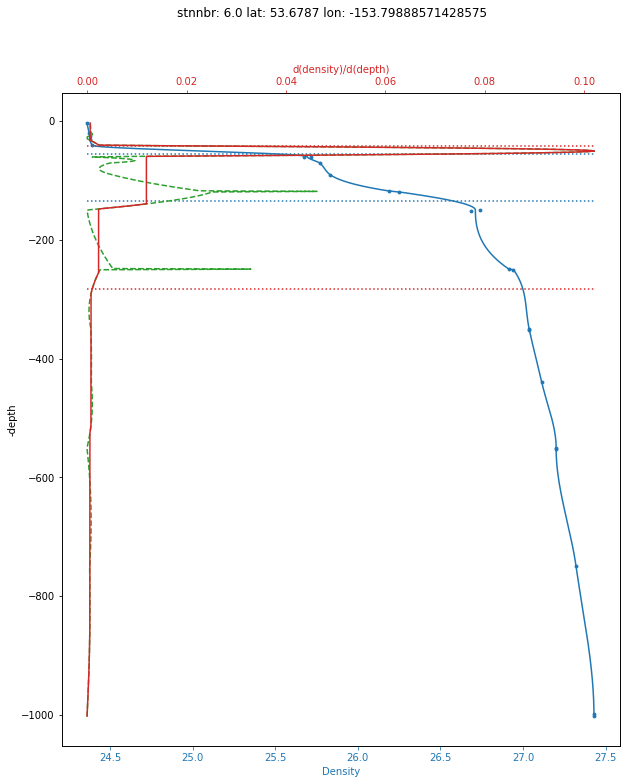

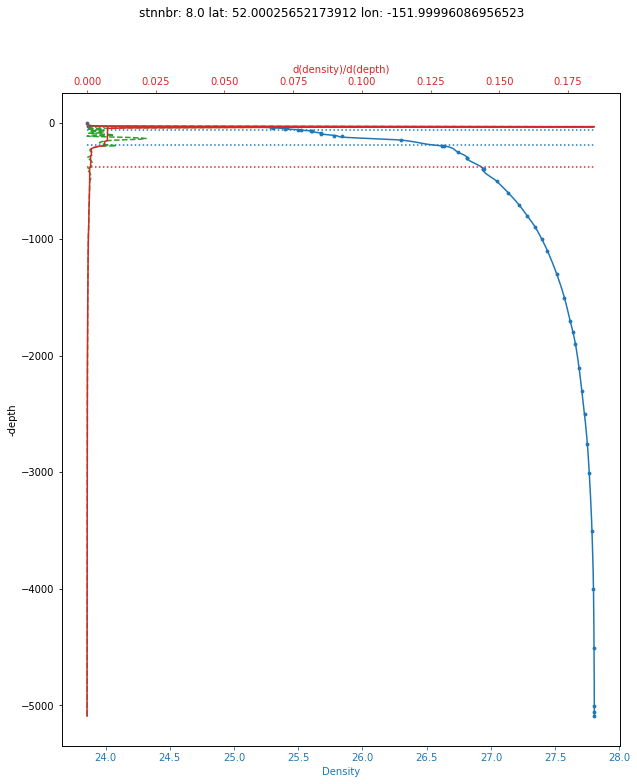

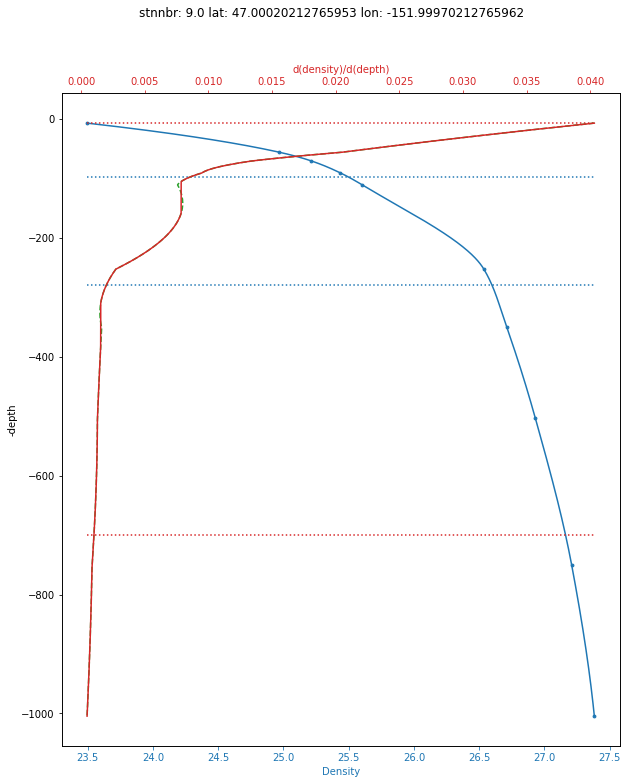

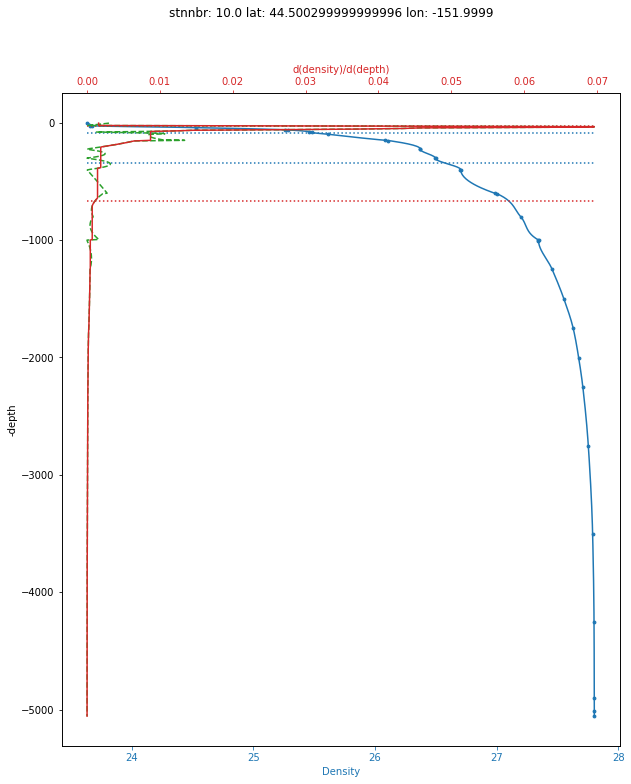

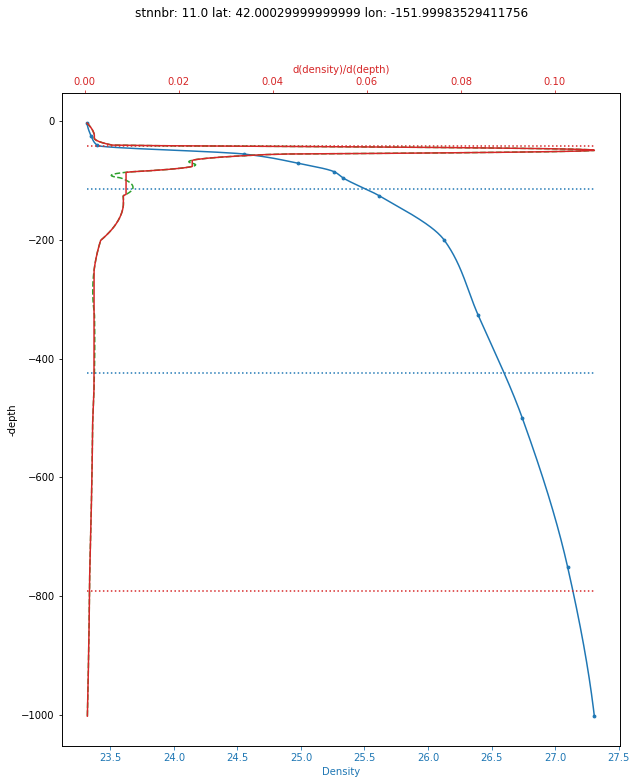

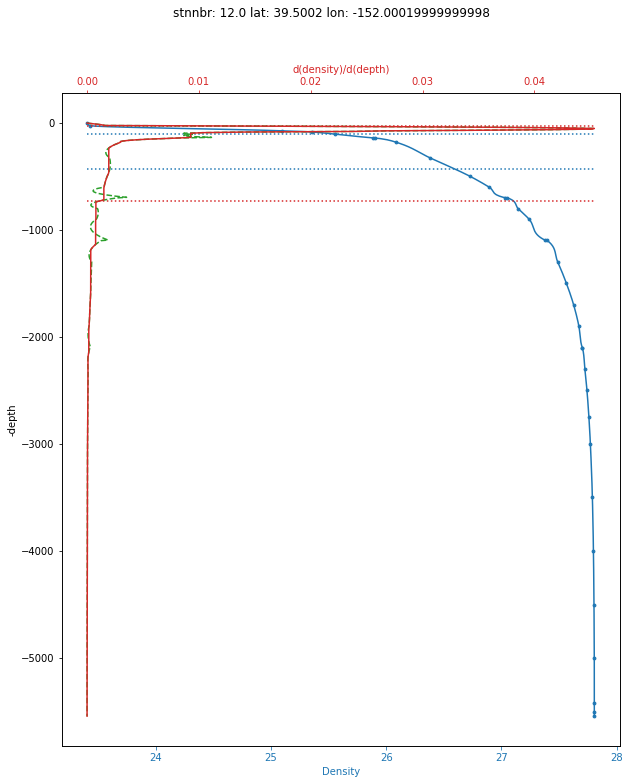

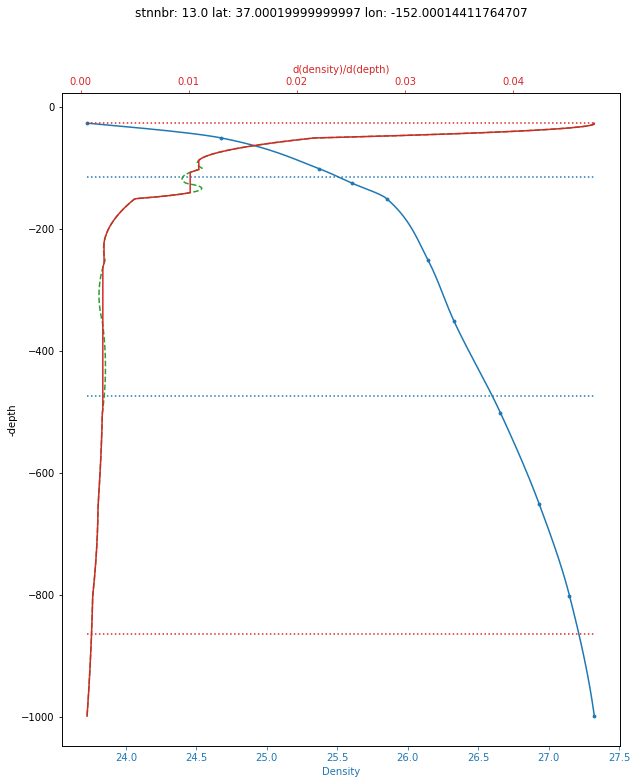

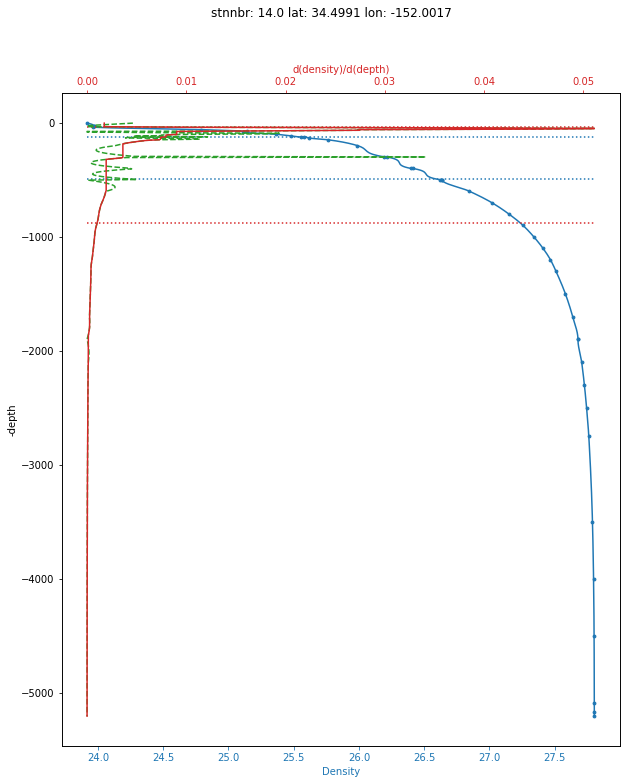

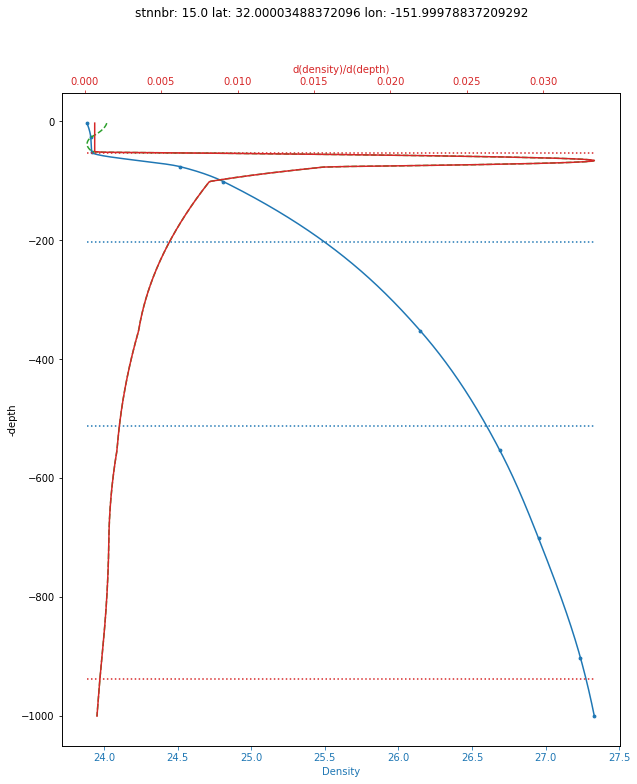

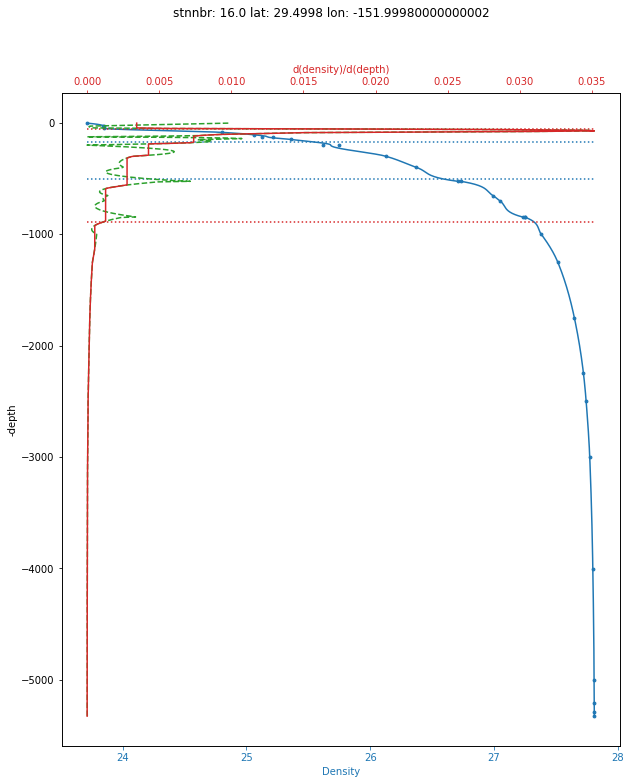

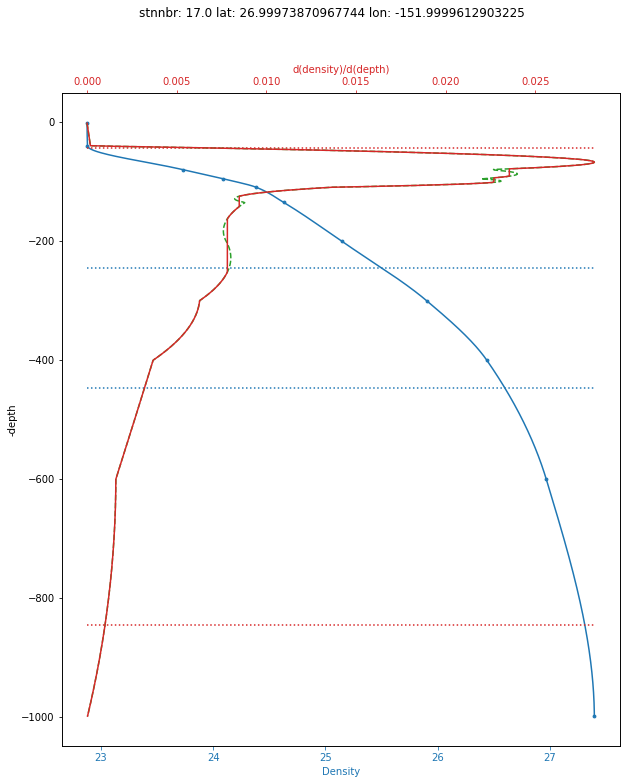

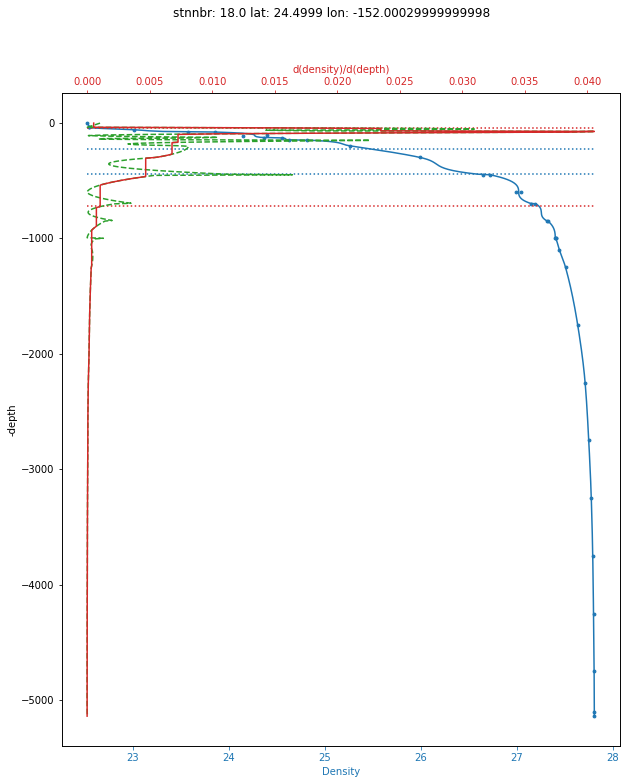

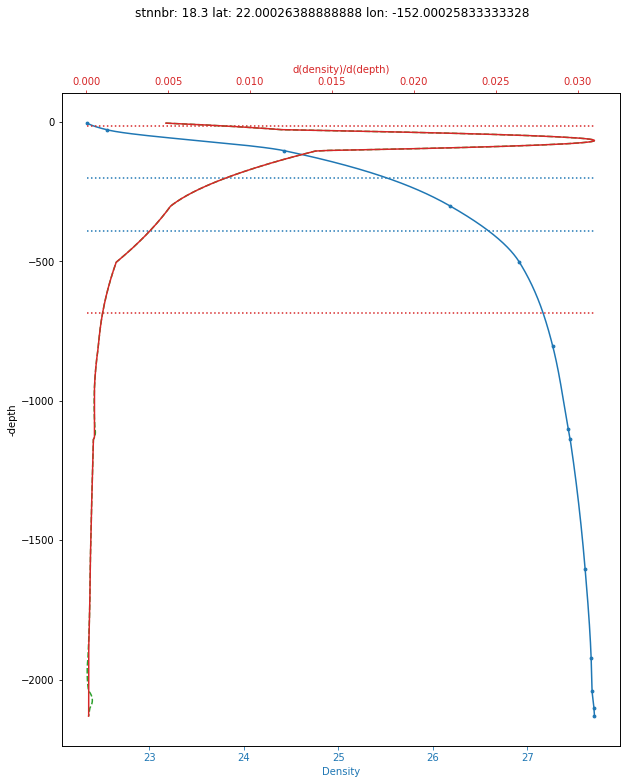

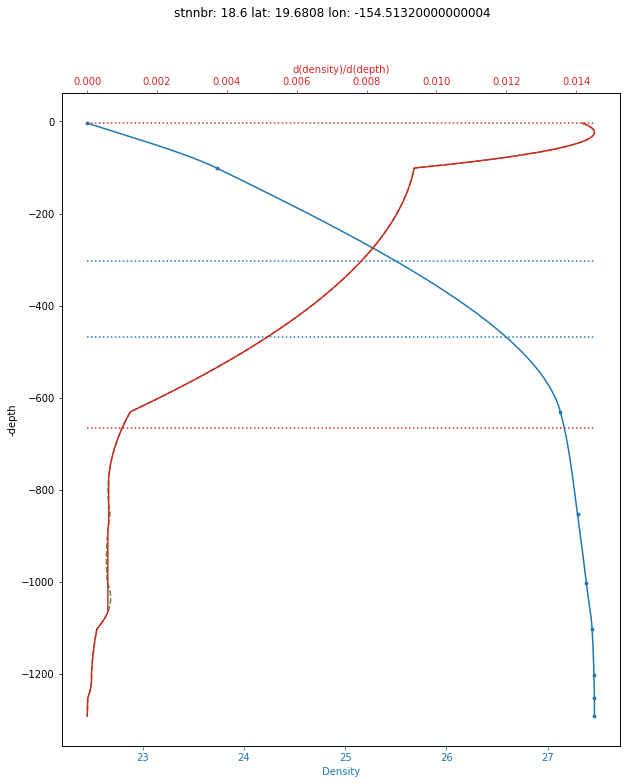

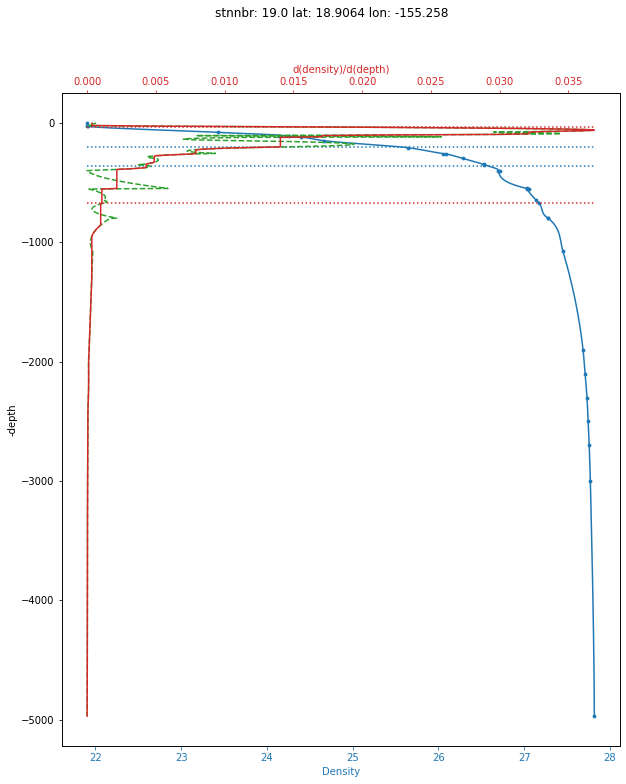

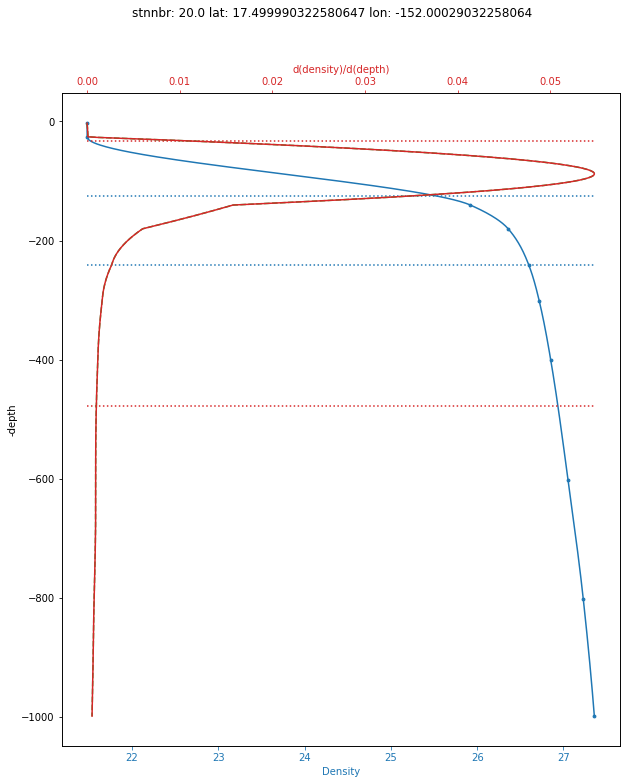

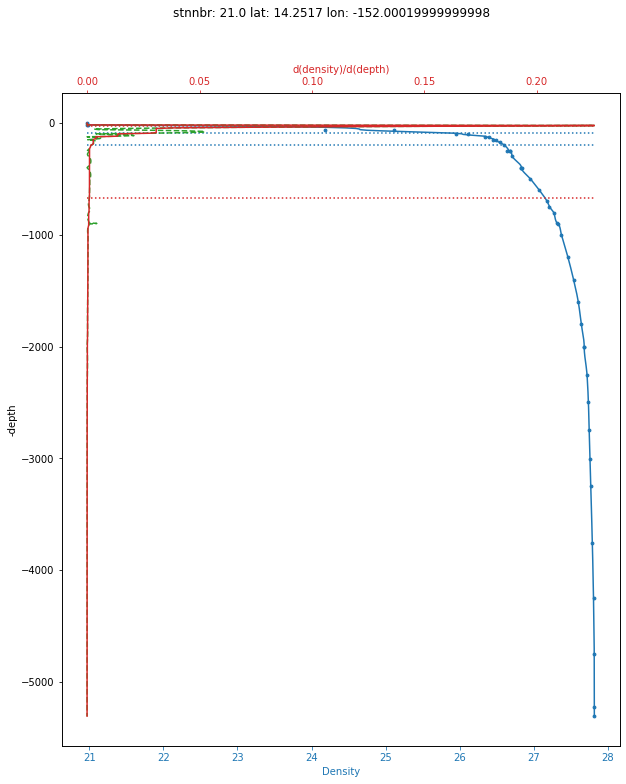

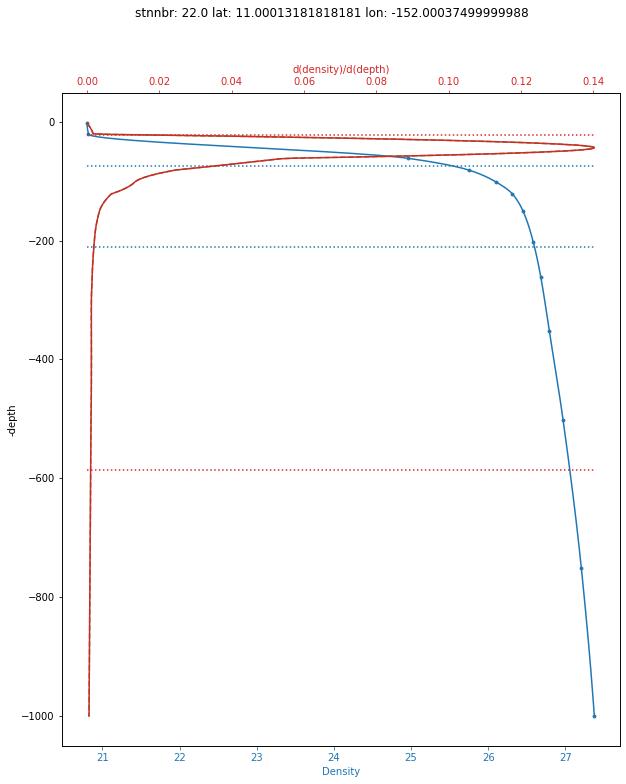

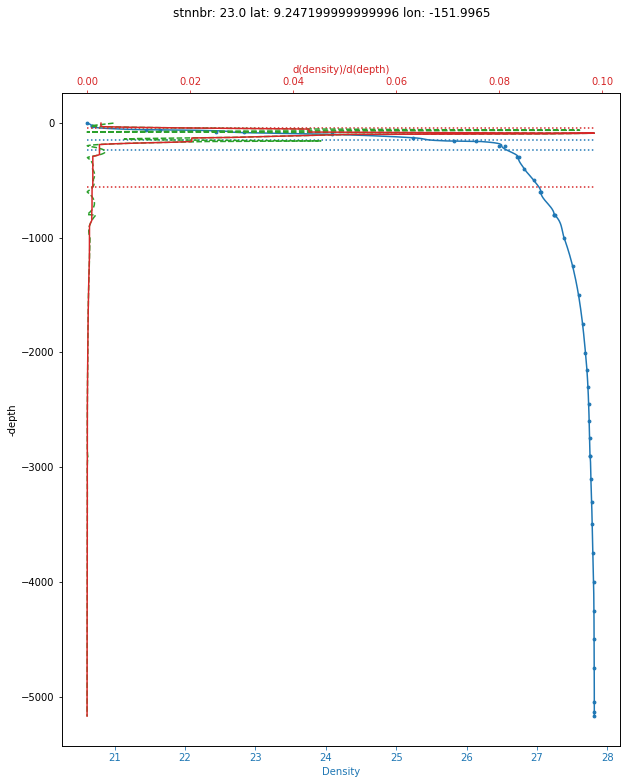

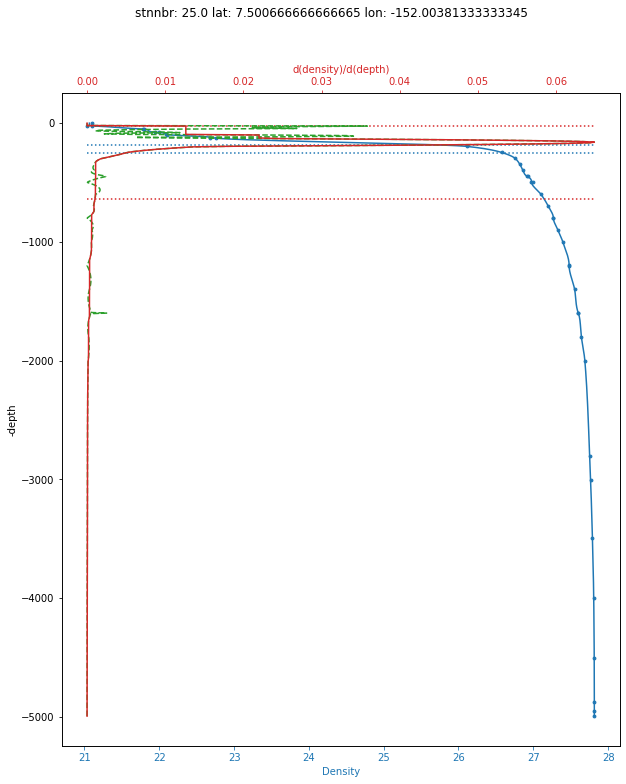

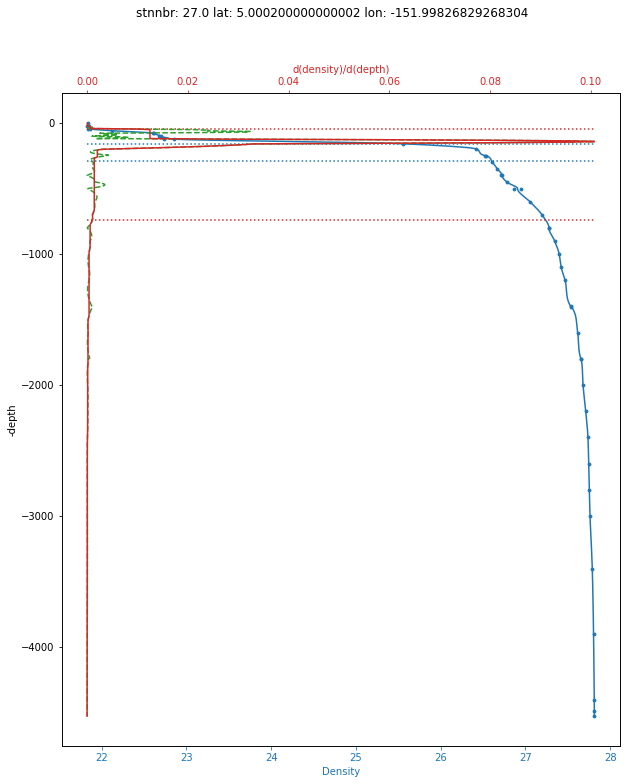

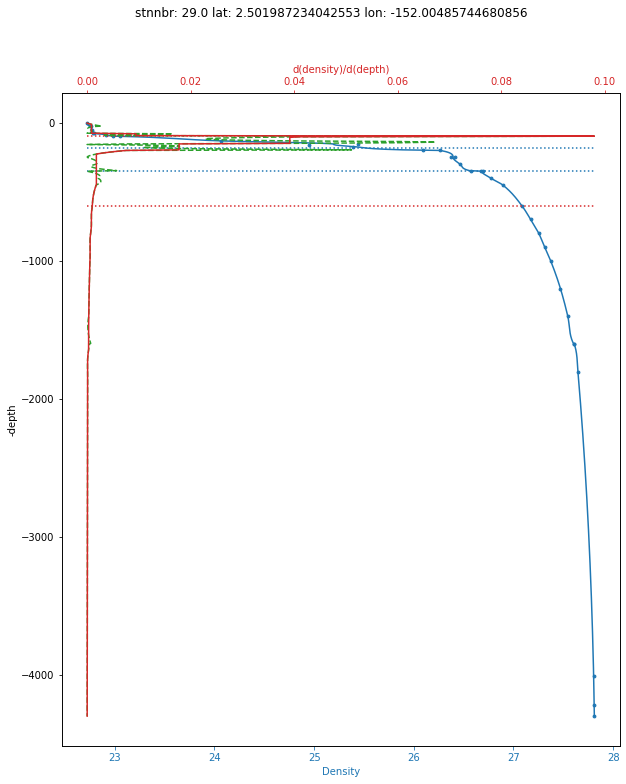

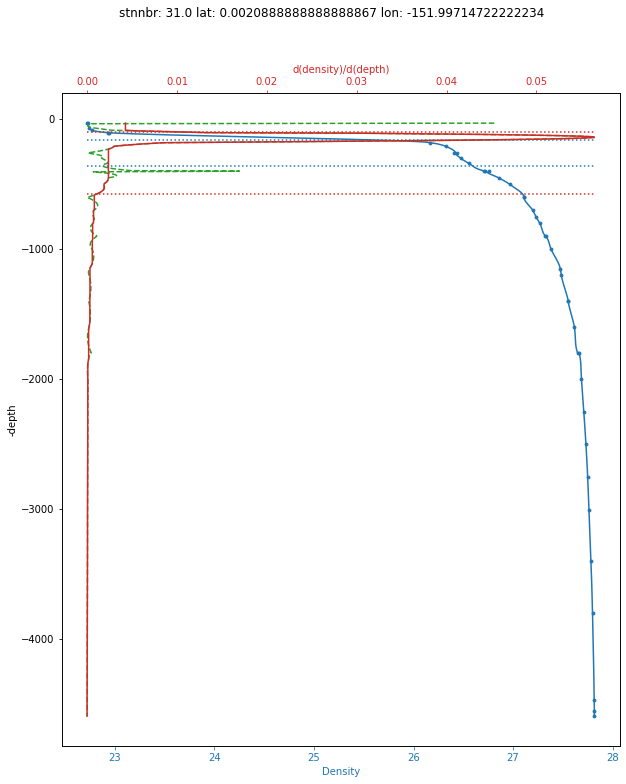

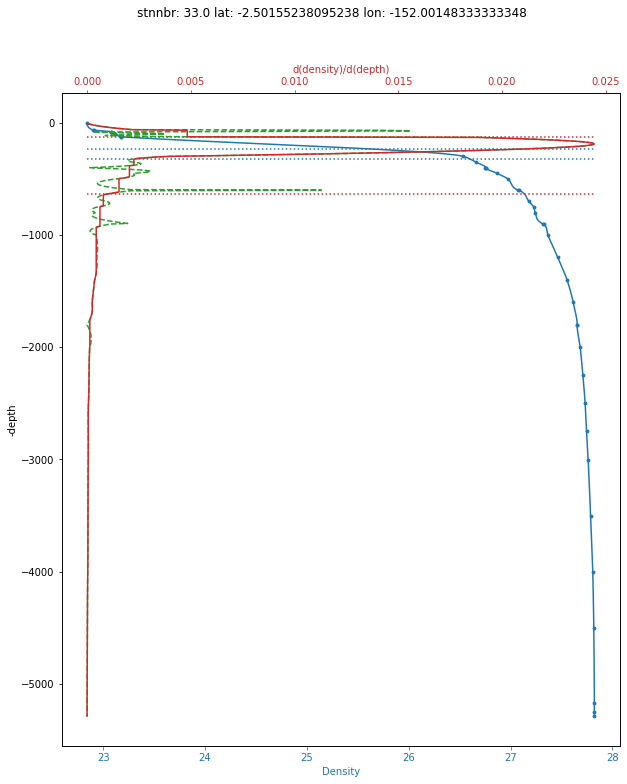

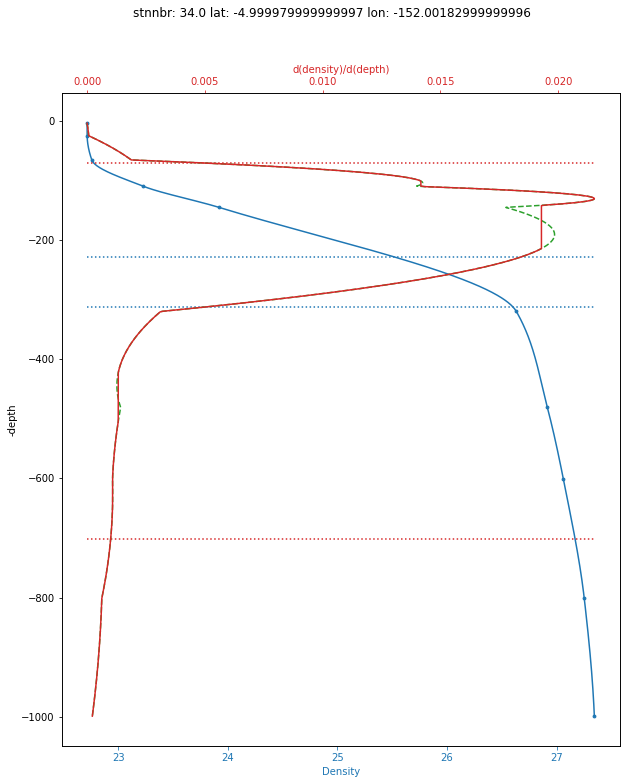

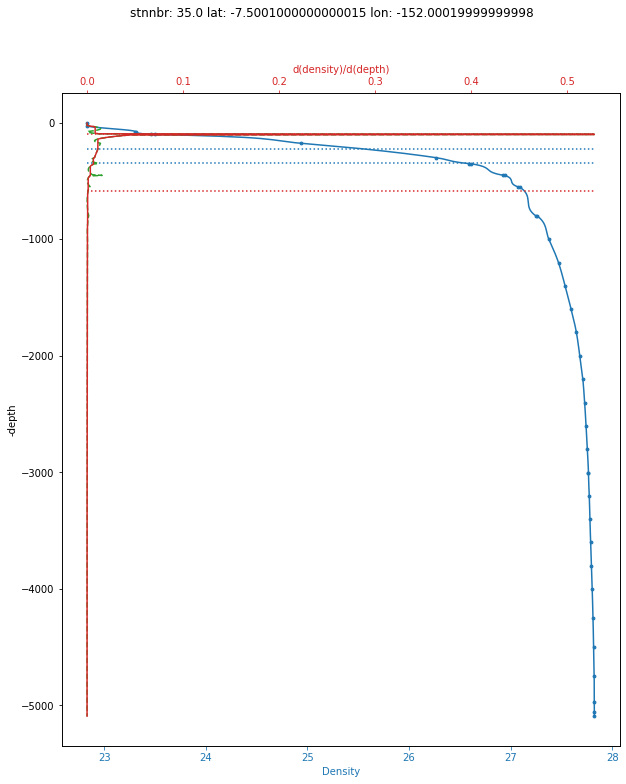

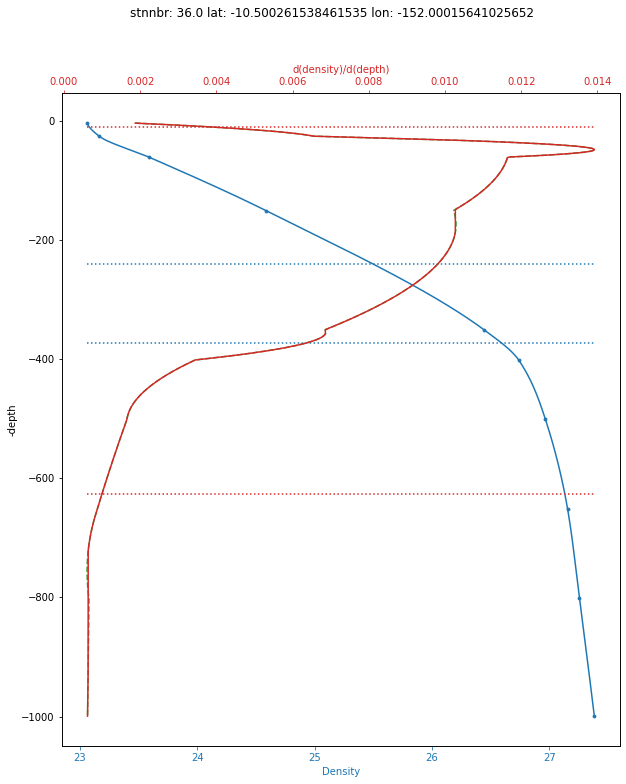

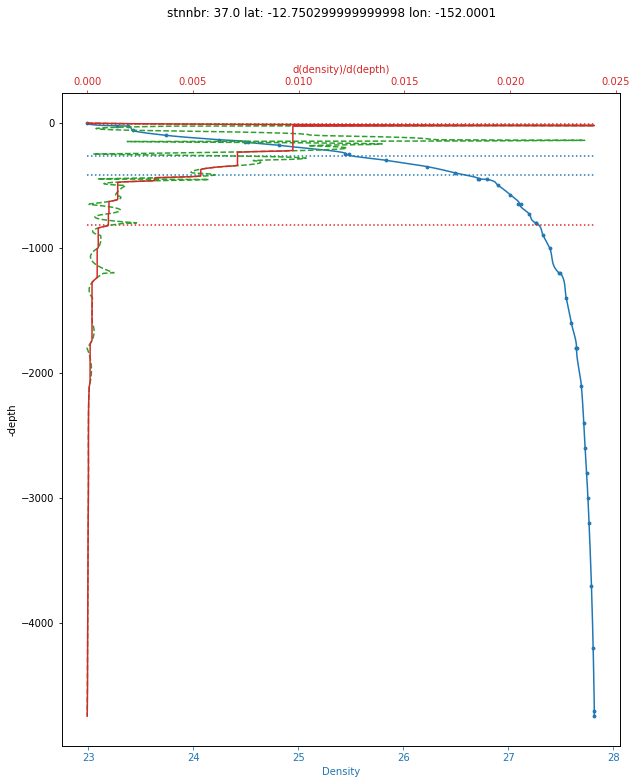

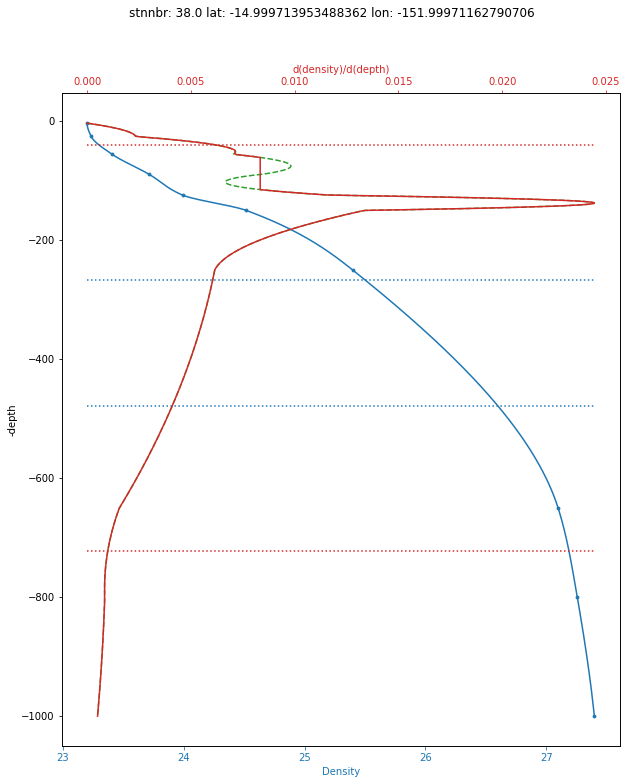

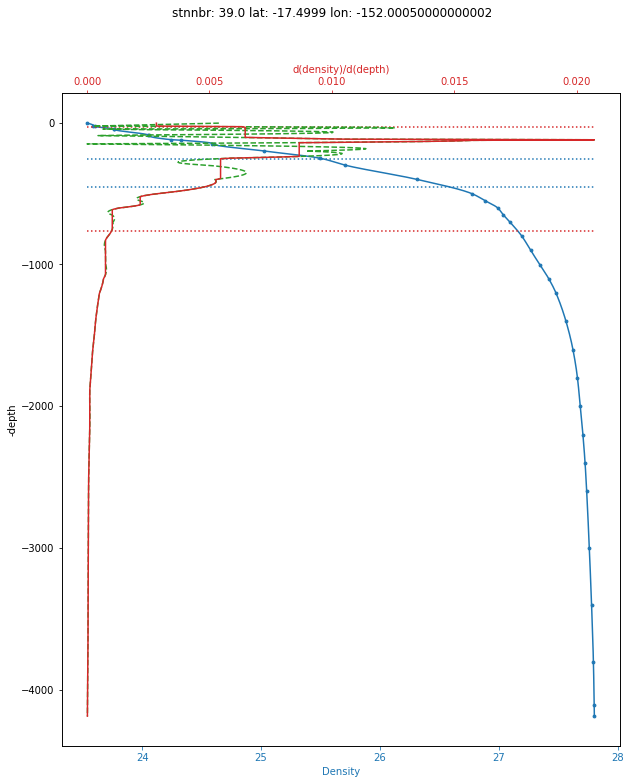

In [83]:
import scipy.interpolate
import scipy.signal
import sklearn.isotonic

#let's plot the profiles per-station
for stnnbr in sorted(set(gp15_df["stnnbr"])):
    stn_obs = gp15_df[gp15_df["stnnbr"]==stnnbr]
    #fit a spline to it
    density = np.array(stn_obs["sigma0"])
    depth = np.array(stn_obs["depth"])

    argsort_depth = np.argsort(depth)
    sorted_depth = depth[argsort_depth]
    sorted_density = density[argsort_depth]
    
    #'correct' the density to enforce monotonic increase with depth
    sorted_monotonic_density = (sklearn.isotonic.IsotonicRegression()
       .fit_transform(X=sorted_depth, y=sorted_density))

    fig, ax1 = plt.subplots(figsize=(10,12))
    fig.suptitle("stnnbr: "+str(stnnbr)
                 +" lat: "+str(lat)
                 +" lon: "+str(lon))
    ax1.set_ylabel("-depth")

    lat = np.mean(stn_obs["lat"])
    lon = np.mean(stn_obs["lon"])

    ax1.scatter(sorted_density, -sorted_depth, s=8, color='C0')
    #ax1.plot(sorted_monotonic_density, -sorted_depth,
    #         color='C0', linestyle="--")
    
    #ax1.plot(sorted_density, -sorted_depth)

    #first_derivatives = (sorted_density[1:]-
    #  sorted_density[:-1])/(sorted_depth[1:]-sorted_depth[:-1])
    #mean_depths_1std = 0.5*(sorted_depth[1:]+sorted_depth[:-1])

    
    #smoothed_depths = savgol_filter(x, 5, 2)
    
    pchip_spl = scipy.interpolate.PchipInterpolator(
                 sorted_depth, sorted_monotonic_density)
    
    #linear_spl = scipy.interpolate.UnivariateSpline(x=sorted_depth,
    #              y=sorted_monotonic_density, k=1, s=0)
    #akima_spl = scipy.interpolate.Akima1DInterpolator(
    #             sorted_depth, sorted_density)
    interp_depths = np.linspace(min(depth), max(depth), 1000)
    interp_density = pchip_spl(interp_depths)

    ###Also try linear spline followed by savgol filter. Ok that had the
    # predictable problems at points of rapid change.
    interp_density_linear = linear_spl(interp_depths)
    
    ax1.plot(interp_density, -interp_depths, color="C0")
    #ax1.plot(interp_density_linear, -interp_depths, color="C2", linestyle="--")
    #ax1.plot(interp_density_linear_smooth, -interp_depths, color="C2")
    ax1.set_xlabel("Density")

    density_cutoff_tc_depths = (
        interp_depths[(interp_density <= TC_UPPER_BOUND)*
                      (interp_density >= TC_LOWER_BOUND)])
    density_cutoff_tc_start_depth = (np.min(density_cutoff_tc_depths) if
      len(density_cutoff_tc_depths) > 0 else np.nan)
    density_cutoff_tc_end_depth = (np.max(density_cutoff_tc_depths) if
      len(density_cutoff_tc_depths) > 0 else np.nan)
    ax1.plot([min(density), max(density)],
             [-density_cutoff_tc_start_depth, -density_cutoff_tc_start_depth],
             color="C0", linestyle=":")
    ax1.plot([min(density), max(density)],
             [-density_cutoff_tc_end_depth, -density_cutoff_tc_end_depth],
             color="C0", linestyle=":")
    #ax1.plot(akima_spl(interp_depths), -interp_depths)

    ax1.tick_params(axis='x', colors='C0')
    ax1.xaxis.label.set_color('C0')
    ax2 = ax1.twiny()
    ax2.tick_params(axis='x', colors='C3')
    ax2.xaxis.label.set_color('C3')

    first_derivatives = pchip_spl.derivative(1)(interp_depths)
    first_derivatives_linearspl = linear_spl.derivative(1)(interp_depths)
    #interp_density_linear_smooth_derivative = scipy.signal.savgol_filter(
    #    x=interp_density_linear, window_length=11, polyorder=2, deriv=1,
    #    delta=(max(depth)-min(depth))/100.0)
    
    ax2.plot(first_derivatives, -interp_depths, color="C2", linestyle="--")
    
    #ax2.plot(first_derivatives_linearspl, -interp_depths, color="C1", linestyle="--")
    ax2.set_xlabel("d(density)/d(depth)")
    #ax2.plot(akima_spl.derivative(1)(interp_depths), -interp_depths, color="green")

    #Procedure: find the maximum of the first derivative, then fit isotonic
    # regression to enforce monotonic increasing and monotic decreasing to
    # get a better estimate of the derivatives.

    max_first_d_depth = np.argmax(first_derivatives)+1
    if (max_first_d_depth > 1):
      increasing_first_d = sklearn.isotonic.IsotonicRegression().fit_transform(
            X=interp_depths[:max_first_d_depth],
            y=first_derivatives[:max_first_d_depth])
    else:
      increasing_first_d = [first_derivatives[0]]
    decreasing_first_d = -sklearn.isotonic.IsotonicRegression().fit_transform(
           X=interp_depths[max_first_d_depth:],
           y=-first_derivatives[max_first_d_depth:])
#    print(decreasing_first_d)

    corrected_first_d = np.array(list(increasing_first_d)
                                 +list(decreasing_first_d))
    ax2.plot(corrected_first_d, -interp_depths, color="C3")

    #threhsolds based on first_d
    THERM_SIGMA0_GRAD_START = min(0.25*np.max(corrected_first_d), 0.01)
    THERM_SIGMA0_GRAD_END = 0.001
    firstd_cutoff_tc_depths = (
        interp_depths[(corrected_first_d >= THERM_SIGMA0_GRAD_START)])
    firstd_cutoff_tc_start_depth = np.min(
        interp_depths[(corrected_first_d >= THERM_SIGMA0_GRAD_START)])
    firstd_cutoff_tc_end_depth = (np.max(
        interp_depths[(corrected_first_d >= THERM_SIGMA0_GRAD_END)]) if
      sum((corrected_first_d >= THERM_SIGMA0_GRAD_END)) > 0 else np.nan)
    ax1.plot([min(density), max(density)],
             [-firstd_cutoff_tc_start_depth, -firstd_cutoff_tc_start_depth],
             color="C3", linestyle=":")
    ax1.plot([min(density), max(density)],
             [-firstd_cutoff_tc_end_depth, -firstd_cutoff_tc_end_depth],
             color="C3", linestyle=":")


    #ax1.plot(sorted_density, -sorted_depth)
    
    ##Procedure:

    #thermocline end 'no higher than xxx'
    #thermocline end 'no lower than xxx'
    #

    
    plt.show()
#plt.show()

In [32]:
interp_depths[interp_density >= TC_LOWER_BOUND]

array([], dtype=float64)

In [ ]:
#Download the end-members .csv for intermediate and deep waters. Note: these
# can also be uploaded by expanding the "files" panel on the left.
!wget https://github.com/nitrogenlab/GP15_watermassanalysis/raw/main/endmember_df_intermediateanddeep.csv
#Download the observations for the intermediate and deep waters (these do not
# include observations in the thermocline)
!wget https://github.com/nitrogenlab/GP15_watermassanalysis/raw/main/gp15_intermediateanddeep_obs.csv
#Download the configuration file
!wget https://github.com/nitrogenlab/GP15_watermassanalysis/raw/main/config_examples/config_example1.txt -O config_file.txt

--2021-01-20 03:28:58--  https://github.com/nitrogenlab/GP15_watermassanalysis/raw/main/endmember_df_intermediateanddeep.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/nitrogenlab/GP15_watermassanalysis/main/endmember_df_intermediateanddeep.csv [following]
--2021-01-20 03:28:58--  https://raw.githubusercontent.com/nitrogenlab/GP15_watermassanalysis/main/endmember_df_intermediateanddeep.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 772 [text/plain]
Saving to: ‘endmember_df_intermediateanddeep.csv’

endmember_df_interm 100%[===================>]     772  --.-KB/s    in 0s      

2021-01-20 0

In [ ]:
from pyompa.parse_config import run_ompa_given_toml_config_file

#Find the ompa solution using the configuration file
ompa_soln = run_ompa_given_toml_config_file("config_file.txt")

Received Config:
{
    "observations": {
        "csv_file": "gp15_intermediateanddeep_obs.csv",
        "na_values": -999
    },
    "endmembers": {
        "csv_file": "endmember_df_intermediateanddeep.csv",
        "endmember_name_column": "watermass_name"
    },
    "params": {
        "potential_temp": {
            "weight": 56.0,
            "remineralized": false
        },
        "practical_salinity": {
            "weight": 80.0,
            "remineralized": false
        },
        "silicate": {
            "weight": 3.0,
            "remineralized": false
        },
        "nitrate": {
            "weight": 5.0,
            "remineralized": true,
            "ratios": [
                0.10330578512,
                0.10330578512
            ]
        },
        "phosphate": {
            "weight": 5.0,
            "remineralized": true,
            "ratios": [
                0.01036168132,
                0.00327210989
            ]
        },
        "oxygen": {
      

Plotting endmember usage penalties


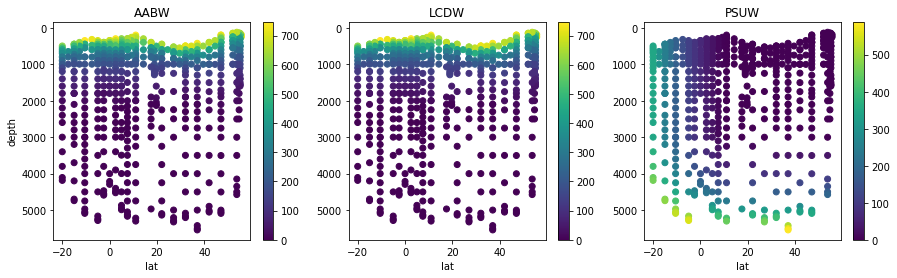

Plotting endmember fractions


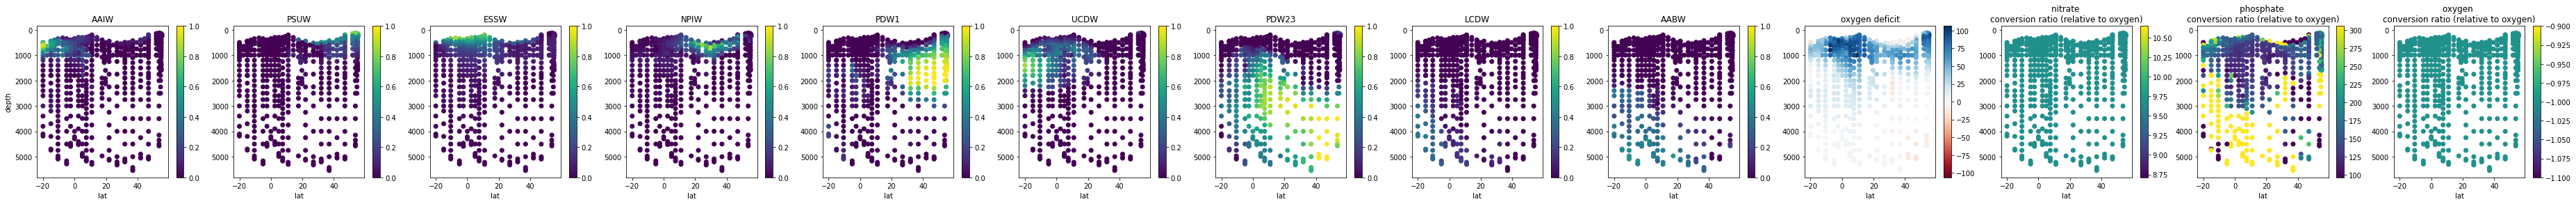

Plotting residuals


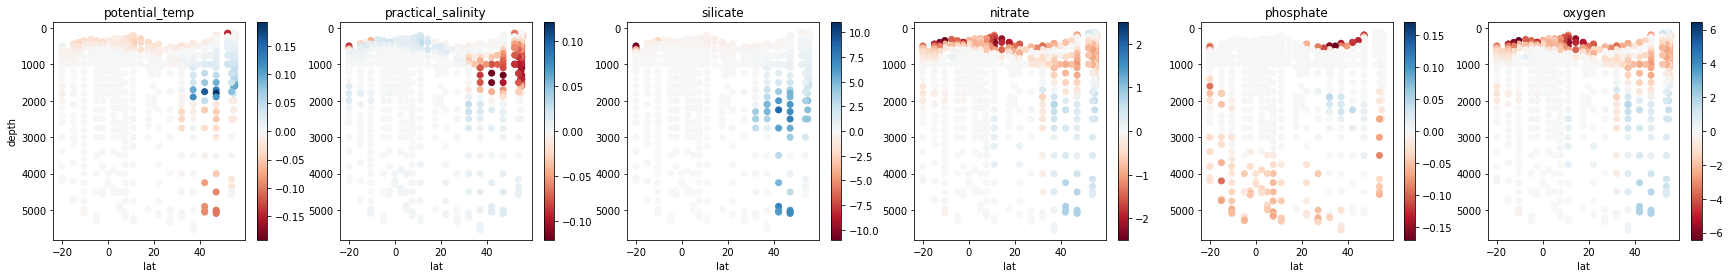

In [ ]:
#Do some plotting
from pyompa import (plot_ompasoln_endmember_fractions,
                    plot_ompasoln_residuals,
                    plot_ompasoln_endmember_usagepenalties)

XAXIS_COLNAME = "lat"
YAXIS_COLNAME = "depth"

if (len(ompa_soln.endmembername_to_usagepenalty) > 0):
    #plot usage penalties if applicable
    print("Plotting endmember usage penalties")
    plot_ompasoln_endmember_usagepenalties(
        ompa_soln, xaxis_colname=XAXIS_COLNAME,
        yaxis_colname=YAXIS_COLNAME)

print("Plotting endmember fractions")
plot_ompasoln_endmember_fractions(ompa_soln, xaxis_colname=XAXIS_COLNAME,
                                  yaxis_colname=YAXIS_COLNAME)
print("Plotting residuals")
plot_ompasoln_residuals(ompa_soln, xaxis_colname=XAXIS_COLNAME,
                        yaxis_colname=YAXIS_COLNAME)

In [ ]:
from pyompa import build_altair_viz

#Build an interactive altair visualization
build_altair_viz(ompa_soln, xaxis_colname="lat", yaxis_colname="depth" )

alt.VConcatChart(...)